In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
from datetime import datetime
from typing import List

In [2]:
raw = pd.read_json(f"{os.getcwd()}/Oct2015.json")

In [3]:
raw

,items
0,"{'project': 'all-projects', 'access': 'mobile-..."
1,"{'project': 'all-projects', 'access': 'mobile-..."
2,"{'project': 'all-projects', 'access': 'mobile-..."
3,"{'project': 'all-projects', 'access': 'mobile-..."
4,"{'project': 'all-projects', 'access': 'mobile-..."
...,...
1459,"{'project': 'all-projects', 'access': 'mobile-..."
1460,"{'project': 'all-projects', 'access': 'mobile-..."
1461,"{'project': 'all-projects', 'access': 'mobile-..."
1462,"{'project': 'all-projects', 'access': 'mobile-..."


In [4]:
df_H = pd.DataFrame([{"date": datetime.strptime(df_line["timestamp"], '%Y%m%d%H'), "count": df_line["views"]} for df_line in raw["items"]])

In [4]:
df_H

,date,count
0,2015-10-01 00:00:00,190238
1,2015-10-01 01:00:00,197807
2,2015-10-01 02:00:00,199163
3,2015-10-01 03:00:00,193361
4,2015-10-01 04:00:00,190302
...,...,...
1459,2015-11-30 19:00:00,341084
1460,2015-11-30 20:00:00,373584
1461,2015-11-30 21:00:00,371526
1462,2015-11-30 22:00:00,324203


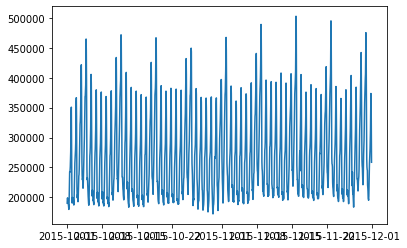

In [5]:
plt.plot(df_H["date"], df_H["count"])

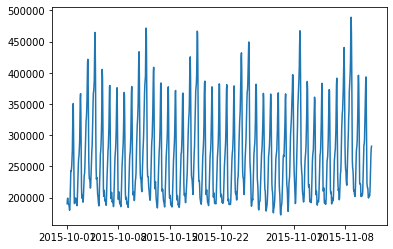

In [25]:
plt.plot(df_H["date"][:1000], df_H["count"][:1000])

In [27]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [28]:
rangenb_df_H = rangenb_loop(df_H["count"])

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_89624/1685401586.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


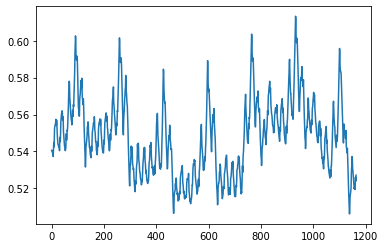

In [29]:
plt.plot(rangenb_df_H)

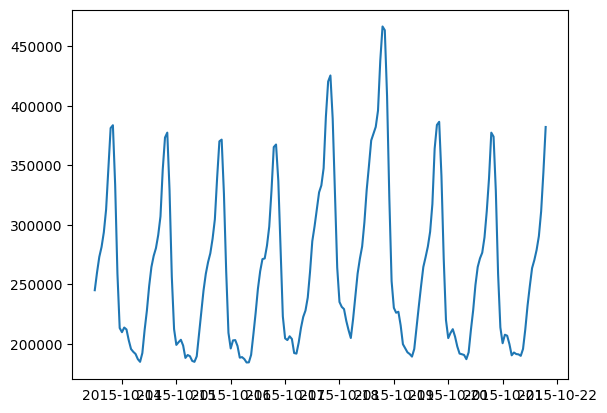

In [7]:
plt.plot(df_H["date"][300:500], df_H["count"][300:500])
plt.savefig("wiki_oct_2015.png")

In [5]:
plt.plot(rangenb_df_H[:200])

NameError: name 'rangenb_df_H' is not defined